# Running a calibration with SHyFT


## This notebook is guiding through the simulation process of a catchment. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**
2. **Configuration of a SHyFT calibration**
3. **Running a SHyFT calibration**
4. **Inspecting the calibration results**


## 1. Loading required python modules and setting path to SHyFT installation

Shyft requires a number of different modules to be loaded as part of the package. Below, we describe the required steps for loading the modules, and note that some steps are only required for the use of the jupyter notebook.

In [1]:
# Pure python modules and jupyter notebook functionality
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
import datetime as dt
import pandas as pd
from os import path
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


### The Shyft Environment

This next step is highly specific on how and where you have installed Shyft. If you have followed the guidelines at github, and cloned the three shyft repositories: i) shyft, ii) shyft-data, and iii) shyft-doc, then you may need to tell jupyter notebooks where to find shyft. Uncomment the relevant lines below.

If you have a 'system' shyft, or used `conda install -s sigbjorn shyft` to install shyft, then you probably will want to make sure you have set the SHYFT_DATA directory correctly, as otherwise, Shyft will assume the above structure and fail. __This has to be done _before_ `import shyft`__. In that case, uncomment the relevant lines below.

**note**: it is most likely that you'll need to do one or the other.

In [2]:
# try to auto-configure the path, -will work in all cases where doc and data
# are checked out at same level
shyft_data_path = path.abspath("../../../shyft-data")
if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path
    
# shyft should be available either by it's install in python
# or by PYTHONPATH set by user prior to starting notebook.
# This is equivalent to the two lines below
#  shyft_path=path.abspath('../../../shyft')
#  sys.path.insert(0,shyft_path)

In [3]:
# importing the shyft modules needed for running a calibration
from shyft.repository.default_state_repository import DefaultStateRepository
from shyft.orchestration.configuration.yaml_configs import YAMLCalibConfig, YAMLSimConfig
from shyft.orchestration.simulators.config_simulator import ConfigCalibrator, ConfigSimulator

## 2. Configuration of a SHyFT calibration

In [4]:
# conduct a configured simulation first.
config_file_path = os.path.abspath("../nea-example/nea-config/neanidelva_simulation.yaml")
cfg = YAMLSimConfig(config_file_path, "neanidelva")
simulator = ConfigSimulator(cfg) 
# run the model, and we'll just pull the `api.model` from the `simulator`
simulator.run()
state = simulator.region_model.state

/Data/johnbur/.conda/envs/shyft-doc/lib/python3.6/site-packages/shyft/repository/netcdf/cf_geo_ts_repository.py:280: RuntimeWarning: invalid value encountered in greater
  pure_arr = data[data_slice]


Running simulation...


Now that we have the initial state, we'll run the calibration (this is not a strictly required step, but we use it later)

In [5]:
# set up configuration using *.yaml configuration files
config_file_path = os.path.abspath("./nea-config/neanidelva_calibration.yaml") # here is the *.yaml file
cfg = YAMLCalibConfig(config_file_path, "neanidelva")

In [6]:
# initialize an instance of the orchestration's ConfigCalcalibrator class, which has all the functionality needed
# to run a calibration using the above initiated configuration
calib = ConfigCalibrator(cfg)
n_cells = calib.region_model.size()
state_repos = DefaultStateRepository(calib.region_model)  # Notice that this repository needs the real model
#                                                           so that it's able to generate a precise
#                                                           default state-with-id vector for this
#                                                           specific model


Creating TargetSpecificationVector...


## 3. Running a SHyFT calibration

In [7]:
# once the calibrator is set up, all you need to do is running the calibration...
# the calibrated parameters are stored in a model.yaml. 
results = calib.calibrate(cfg.sim_config.time_axis, state_repos.get_state(0).state_vector, 
                          cfg.optimization_method['name'],
                          cfg.optimization_method['params'])

/Data/johnbur/.conda/envs/shyft-doc/lib/python3.6/site-packages/shyft/repository/netcdf/cf_geo_ts_repository.py:280: RuntimeWarning: invalid value encountered in greater
  pure_arr = data[data_slice]


Calibrating...
Storing calibrated params in: /Data/johnbur/Dropbox/home/Programming/workspace/shyft_workspace/shyft-doc/notebooks/nea-example/nea-config/neanidelva_model_calibrated.yaml


## 4. Inspecting the calibration results
First the Nash-Suttcliffe-efficiency of the calibrated simulation is computed to see the quality of the calibration.
Then the calibrated model parameters are accessed and printed out.

In [8]:
# Get NSE of calibrated run:
result_params = []
for i in range(results.size()):
    result_params.append(results.get(i))
print("Final NSE =", 1-calib.optimizer.calculate_goal_function(result_params))

Final NSE = 0.7667993968973358


In [9]:
# Check out the calibrated parameters.

diff = 1.0E-3
print("{0:30s} {1:10s}".format("PARAM-NAME", "CALIB-VALUE"))

for i in range(results.size()):
    print("{0:30s} {1:10f}".format(results.get_name(i), results.get(i)))

PARAM-NAME                     CALIB-VALUE
kirchner.c1                     -3.875284
kirchner.c2                      0.146212
kirchner.c3                     -0.059750
ae.ae_scale_factor               1.500000
gs.tx                           -0.720852
gs.wind_scale                    3.033541
gs.max_water                     0.100000
gs.wind_const                    3.320394
gs.fast_albedo_decay_rate       11.274478
gs.slow_albedo_decay_rate       30.899840
gs.surface_magnitude            30.000000
gs.max_albedo                    0.900000
gs.min_albedo                    0.455354
gs.snowfall_reset_depth          5.000000
gs.snow_cv                       0.400000
gs.glacier_albedo                0.400000
p_corr.scale_factor              1.030839
gs.snow_cv_forest_factor         0.000000
gs.snow_cv_altitude_factor       0.000000
pt.albedo                        0.200000
pt.alpha                         1.260000
gs.initial_bare_ground_fraction   0.040000
gs.winter_end_day_of_year      1

### Plotting simulated and observed discharge
We are now plotting the simulated and observed discharge timeseries over the course of the melt period.


In [17]:
# get the target vector and discharge statistics from the configured calibrator
target_obs = calib.tv[0]
disch_sim = calib.region_model.statistics.discharge(target_obs.catchment_indexes)
disch_obs = target_obs.ts.values

ts_timestamps = [dt.datetime.utcfromtimestamp(p.start) for p in target_obs.ts.time_axis]


Text(0,0.5,'discharge [m3 s-1]')

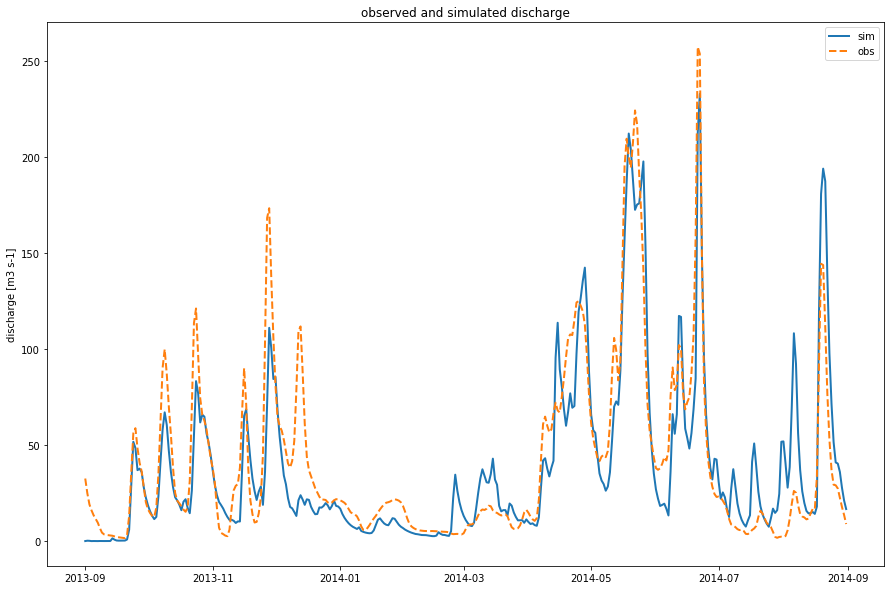

In [11]:
# plot up the results
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps, disch_sim.values, lw=2, label = "sim")
ax.plot(ts_timestamps, disch_obs, lw=2, ls='--', label = "obs")
ax.set_title("observed and simulated discharge")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

## 5. Changing parameters on-the-fly
Instead of changing model parameters in the yaml-configs, reload the configuration and re-run the model, we can also just change the parameters "on-the-fly", and rerun the model. This makes it easy to investigate the influence of certain model parameters on the simulation results.

### 5a. Snow or rain? The parameter gs.tx sets the threshold temperature at which precipitation is treated as snow fall.

In the following we'll investigate the impact of manually manipulating this parameter.

In [12]:
parameters = calib.region_model.get_region_parameter() # fetching parameters from the simulator object
print(u"Calibrated rain/snow threshold temp: {} C".format(parameters.gs.tx)) # print current value of hs.tx

Calibrated rain/snow threshold temp: -0.7208517659857638 C


In the following, we first set the hs.tx parameter to a higher, and then to a lower value compared to the value the calibration results suggest. We re-run the simulation, respicetively, and plot the results.

/Data/johnbur/.conda/envs/shyft-doc/lib/python3.6/site-packages/shyft/repository/netcdf/cf_geo_ts_repository.py:280: RuntimeWarning: invalid value encountered in greater
  pure_arr = data[data_slice]


Running simulation...
Running simulation...


Text(0,0.5,'discharge [m3 s-1]')

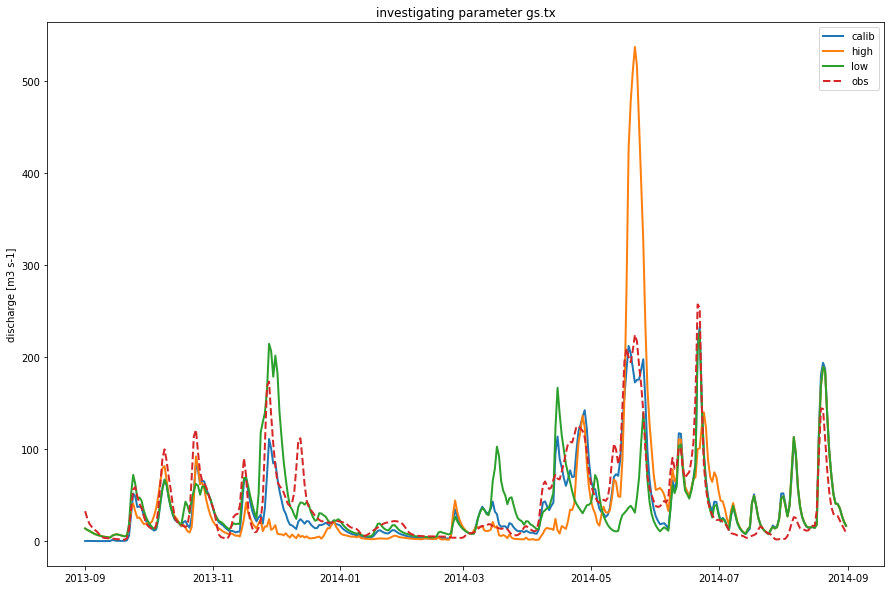

In [13]:
calib.optimizer.calculate_goal_function(result_params) # reset the parameters to the values of the calibration
parameters.gs.tx = 4.0 # setting a higher value for tx
s_init = state.extract_state([])
# type(state)
# s0=state_repos.get_state(0)
# s0.state_vector
# state.apply_state(s0, [])
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
parameters.gs.tx = -4.0 # setting a higher value for tx

calib.run(state=s_init) # rerun the model, with new parameter

disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps, disch_obs, lw=2, ls='--', label = "obs")
ax.set_title("investigating parameter gs.tx")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")

/Data/johnbur/.conda/envs/shyft-doc/lib/python3.6/site-packages/shyft/repository/netcdf/cf_geo_ts_repository.py:280: RuntimeWarning: invalid value encountered in greater
  pure_arr = data[data_slice]


Running simulation...
Running simulation...


Text(0,0.5,'discharge [m3 s-1]')

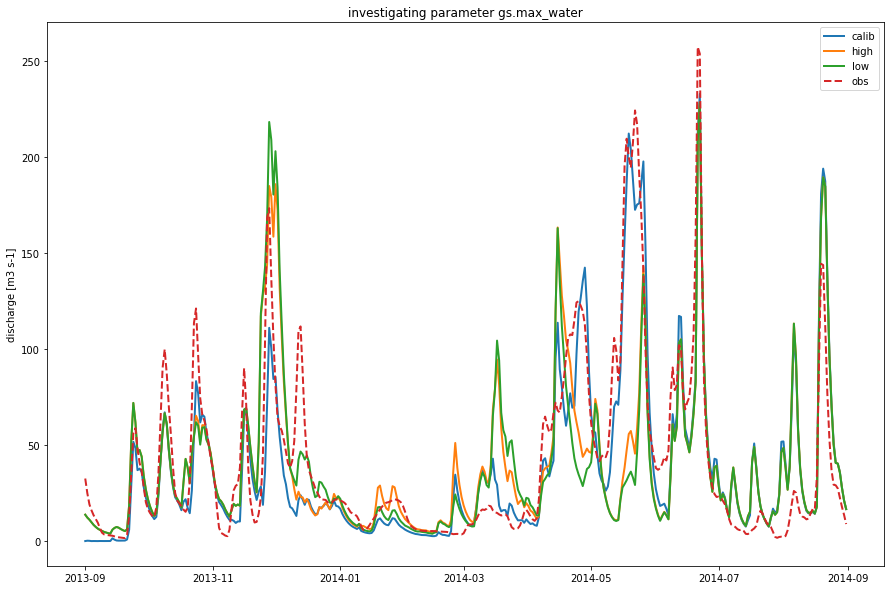

In [14]:
s_init = state.extract_state([])

# reset the max water parameter
parameters.gs.max_water = 1.0 # setting a higher value for tx
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_high = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts

parameters.gs.max_water = .001 # setting a higher value for tx
calib.run(state=s_init) # rerun the model, with new parameter
disch_sim_p_low = calib.region_model.statistics.discharge(target_obs.catchment_indexes) # fetch discharge ts

# plot the results
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(ts_timestamps, disch_sim.values, lw=2, label = "calib")
ax.plot(ts_timestamps, disch_sim_p_high.values, lw=2, label = "high")
ax.plot(ts_timestamps, disch_sim_p_low.values, lw=2, label = "low")
ax.plot(ts_timestamps, disch_obs, lw=2, ls='--', label = "obs")
ax.set_title("investigating parameter gs.max_water")
ax.legend()
ax.set_ylabel("discharge [m3 s-1]")